MOUNTING GOOGLE DRIVE

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


importing library files

In [2]:
!pip install scipy==1.1.0
from scipy import misc
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt

     |████████████████████████████████| 31.2 MB 60 kB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.4 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
plotnine 0.6.0 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
jax 0.2.21 requires scipy>=1.2.1, but you have scipy 1.1.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Load image into variable and display it

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  


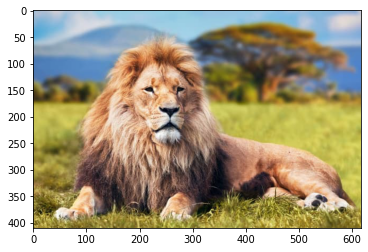

In [3]:
import scipy
lion = scipy.misc.imread("/content/drive/MyDrive/ivp/assignment/lion_ivp.jpeg") 
plt.imshow(lion, cmap = plt.get_cmap('gray'))
plt.show()

 Convert color image to grayscale to help extraction of edges and plot it


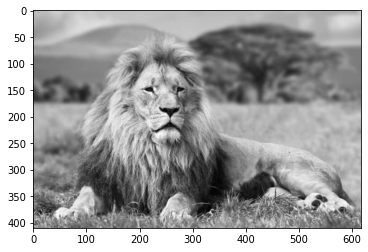

In [4]:
lion_gray = np.dot(lion[...,:3], [0.299, 0.587, 0.114])
plt.imshow(lion_gray, cmap = plt.get_cmap('gray'))
plt.show()

Blur the grayscale image so that only important edges are extracted and the noisy ones ignored


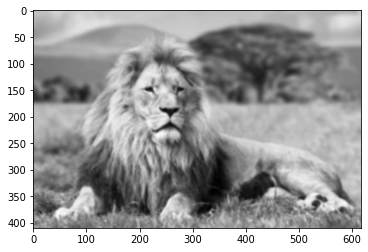

In [5]:
lion_gray_blurred = ndimage.gaussian_filter(lion_gray, sigma=1.4) 
plt.imshow(lion_gray_blurred, cmap = plt.get_cmap('gray'))
plt.show()

Apply Sobel Filter using the convolution operation

Note that in this case I have used the filter to have a maximum amgnitude of 2, but it can also be changed to other numbers for aggressive edge extraction
 For eg [-1,0,1], [-5,0,5], [-1,0,1]

In [6]:
def SobelFilter(img, direction):
    if(direction == 'x'):
        Gx = np.array([[-1,0,+1], [-2,0,+2],  [-1,0,+1]])
        Res = ndimage.convolve(img, Gx)
        
    if(direction == 'y'):
        Gy = np.array([[-1,-2,-1], [0,0,0], [+1,+2,+1]])
        Res = ndimage.convolve(img, Gy)
        
    
    return Res

Normalize the pixel array, so that values are <= 1


In [7]:
def Normalize(img):
    img = img/np.max(img)
    return img

Apply Sobel Filter in X direction


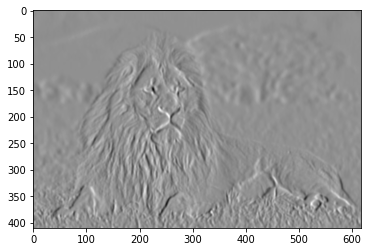

In [8]:
gx = SobelFilter(lion_gray_blurred, 'x')
gx = Normalize(gx)
plt.imshow(gx, cmap = plt.get_cmap('gray'))
plt.show()

Apply Sobel Filter in Y direction


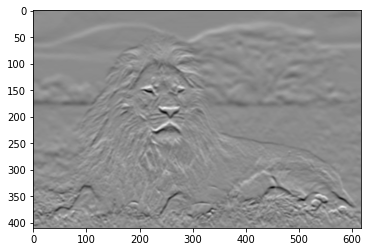

In [9]:
gy = SobelFilter(lion_gray_blurred, 'y')
gy = Normalize(gy)
plt.imshow(gy, cmap = plt.get_cmap('gray'))
plt.show()

Apply the Sobel Filter using the inbuilt function of scipy, this was done to verify the values obtained from above
Also differnet modes can be tried out for example as given below:
dx = ndimage.sobel(lion_gray_blurred, axis=1, mode='constant', cval=0.0)  # horizontal derivative
dy = ndimage.sobel(lion_gray_blurred, axis=0, mode='constant', cval=0.0)  # vertical derivative

In [10]:
dx = ndimage.sobel(lion_gray_blurred, axis=1) 
dy = ndimage.sobel(lion_gray_blurred, axis=0) 

Plot the derivative filter values obtained using the inbuilt function


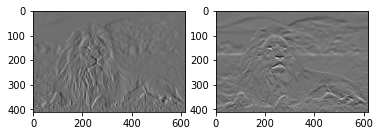

In [11]:
plt.subplot(121)
plt.imshow(dx, cmap = plt.get_cmap('gray'))
plt.subplot(122)
plt.imshow(dy, cmap = plt.get_cmap('gray'))
plt.show()

Calculate the magnitude of the gradients obtained

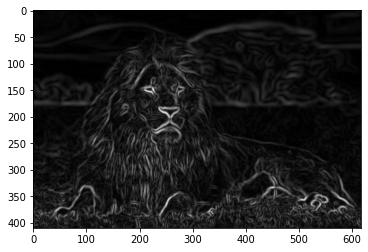

In [12]:
Mag = np.hypot(gx,gy)
Mag = Normalize(Mag)
plt.imshow(Mag, cmap = plt.get_cmap('gray'))
plt.show()

Calculate the magnitude of the gradients obtained using the inbuilt function, again done to verify the correctness of the above value

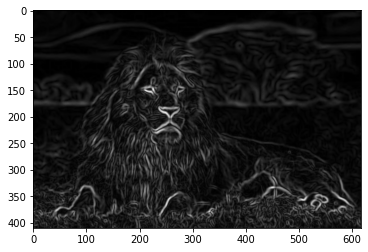

In [13]:
mag = np.hypot(dx,dy)
mag = Normalize(mag)
plt.imshow(mag, cmap = plt.get_cmap('gray'))
plt.show()

Calculate direction of the gradients

In [14]:
Gradient = np.degrees(np.arctan2(gy,gx))

Calculate the direction of the gradients obtained using the inbuilt sobel function

In [15]:
gradient = np.degrees(np.arctan2(dy,dx))

Do Non Maximum Suppression with interpolation to get a better estimate of the magnitude values of the pixels in the gradient direction
This is done to get thin edges

In [16]:
def NonMaxSupWithInterpol(Gmag, Grad, Gx, Gy):
    NMS = np.zeros(Gmag.shape)
    
    for i in range(1, int(Gmag.shape[0]) - 1):
        for j in range(1, int(Gmag.shape[1]) - 1):
            if((Grad[i,j] >= 0 and Grad[i,j] <= 45) or (Grad[i,j] < -135 and Grad[i,j] >= -180)):
                yBot = np.array([Gmag[i,j+1], Gmag[i+1,j+1]])
                yTop = np.array([Gmag[i,j-1], Gmag[i-1,j-1]])
                x_est = np.absolute(Gy[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] > 45 and Grad[i,j] <= 90) or (Grad[i,j] < -90 and Grad[i,j] >= -135)):
                yBot = np.array([Gmag[i+1,j] ,Gmag[i+1,j+1]])
                yTop = np.array([Gmag[i-1,j] ,Gmag[i-1,j-1]])
                x_est = np.absolute(Gx[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] > 90 and Grad[i,j] <= 135) or (Grad[i,j] < -45 and Grad[i,j] >= -90)):
                yBot = np.array([Gmag[i+1,j] ,Gmag[i+1,j-1]])
                yTop = np.array([Gmag[i-1,j] ,Gmag[i-1,j+1]])
                x_est = np.absolute(Gx[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] > 135 and Grad[i,j] <= 180) or (Grad[i,j] < 0 and Grad[i,j] >= -45)):
                yBot = np.array([Gmag[i,j-1] ,Gmag[i+1,j-1]])
                yTop = np.array([Gmag[i,j+1] ,Gmag[i-1,j+1]])
                x_est = np.absolute(Gy[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
    
    return NMS
                
            

This is also non-maxima suppression but without interpolation i.e. the pixel closest to the gradient direction is used as the estimate

In [17]:
def NonMaxSupWithoutInterpol(Gmag, Grad):
    NMS = np.zeros(Gmag.shape)
    for i in range(1, int(Gmag.shape[0]) - 1):
        for j in range(1, int(Gmag.shape[1]) - 1):
            if((Grad[i,j] >= -22.5 and Grad[i,j] <= 22.5) or (Grad[i,j] <= -157.5 and Grad[i,j] >= 157.5)):
                if((Gmag[i,j] > Gmag[i,j+1]) and (Gmag[i,j] > Gmag[i,j-1])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] >= 22.5 and Grad[i,j] <= 67.5) or (Grad[i,j] <= -112.5 and Grad[i,j] >= -157.5)):
                if((Gmag[i,j] > Gmag[i+1,j+1]) and (Gmag[i,j] > Gmag[i-1,j-1])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] >= 67.5 and Grad[i,j] <= 112.5) or (Grad[i,j] <= -67.5 and Grad[i,j] >= -112.5)):
                if((Gmag[i,j] > Gmag[i+1,j]) and (Gmag[i,j] > Gmag[i-1,j])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] >= 112.5 and Grad[i,j] <= 157.5) or (Grad[i,j] <= -22.5 and Grad[i,j] >= -67.5)):
                if((Gmag[i,j] > Gmag[i+1,j-1]) and (Gmag[i,j] > Gmag[i-1,j+1])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0

    return NMS

Get the Non-Max Suppressed output

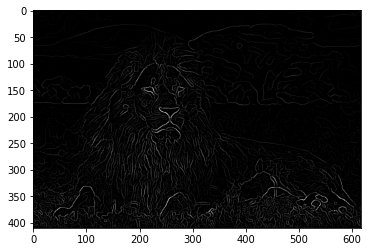

In [18]:
NMS = NonMaxSupWithInterpol(Mag, Gradient, gx, gy)
NMS = Normalize(NMS)
plt.imshow(NMS, cmap = plt.get_cmap('gray'))
plt.show()

Get the Non-max suppressed output on the same image but using the image using the inbuilt sobel operator

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


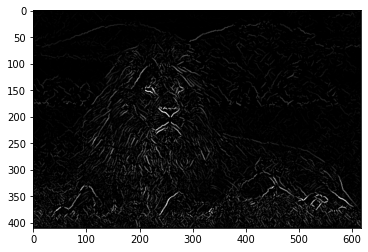

In [19]:
nms = NonMaxSupWithInterpol(mag, gradient, dx, dy)
nms = Normalize(nms)
plt.imshow(nms, cmap = plt.get_cmap('gray'))
plt.show()

Double threshold Hysterisis

In [22]:
def DoThreshHyst(img):
    highThresholdRatio = 0.2  
    lowThresholdRatio = 0.15 
    GSup = np.copy(img)
    h = int(GSup.shape[0])
    w = int(GSup.shape[1])
    highThreshold = np.max(GSup) * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio    
    x = 0.1
    oldx=0
    
    while(oldx != x):
        oldx = x
        for i in range(1,h-1):
            for j in range(1,w-1):
                if(GSup[i,j] > highThreshold):
                    GSup[i,j] = 1
                elif(GSup[i,j] < lowThreshold):
                    GSup[i,j] = 0
                else:
                    if((GSup[i-1,j-1] > highThreshold) or 
                        (GSup[i-1,j] > highThreshold) or
                        (GSup[i-1,j+1] > highThreshold) or
                        (GSup[i,j-1] > highThreshold) or
                        (GSup[i,j+1] > highThreshold) or
                        (GSup[i+1,j-1] > highThreshold) or
                        (GSup[i+1,j] > highThreshold) or
                        (GSup[i+1,j+1] > highThreshold)):
                        GSup[i,j] = 1
        x = np.sum(GSup == 1)
    
    GSup = (GSup == 1) * GSup 
    
    return GSup
                

The output of canny edge detection 


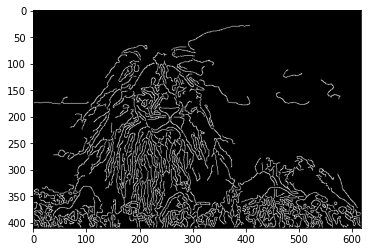

In [23]:
Final_Image = DoThreshHyst(NMS)
plt.imshow(Final_Image, cmap = plt.get_cmap('gray'))
plt.show()

The output of canny edge detection using the inputs obtaind using the inbuilt sobel operator

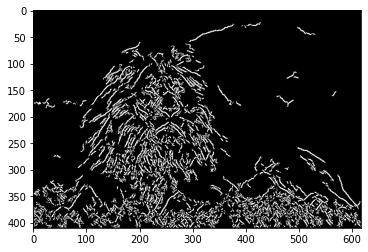

In [24]:
final_image = DoThreshHyst(nms)
plt.imshow(final_image, cmap = plt.get_cmap('gray'))
plt.show()